# How to perform a cutting workflow with multiple observables

### Create a circuit to cut

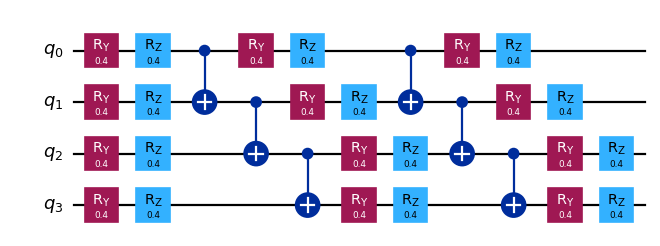

In [1]:
from qiskit.circuit.library import EfficientSU2

qc = EfficientSU2(4, entanglement="linear", reps=2).decompose()
qc.assign_parameters([0.4] * len(qc.parameters), inplace=True)

qc.draw("mpl", scale=0.8)

### Specify the observables of interest

In [2]:
from qiskit.quantum_info import Pauli, SparsePauliOp

observables = [
    Pauli("-XZII"),
    SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"]),
]

### Gather unique observable terms

In [3]:
from qiskit_addon_cutting.utils.observable_terms import gather_unique_observable_terms

unique_observable_terms = gather_unique_observable_terms(observables)

### Perform cutting workflow

In [4]:
from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc, partition_labels="AABB", observables=unique_observable_terms
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables

In [5]:
import numpy as np
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

In [6]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()

In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Transpile the subexperiments to ISA circuits
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

In [8]:
from qiskit_ibm_runtime import SamplerV2, Batch

# Submit each partition's subexperiments as a single batch
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }

/home/garrison/middleware/.direnv/python-3.11.0/lib/python3.11/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


In [9]:
# Retrieve results
results = {label: job.result() for label, job in jobs.items()}

### Reconstruct the expectation value of each unique term

In [10]:
from qiskit_addon_cutting import reconstruct_expectation_values

# Get expectation values for each observable term
reconstructed_term_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,  # or unique_observable_terms if the circuit did not separate
)

### Reconstruct the expectation value of the original operators

In [11]:
from qiskit_addon_cutting.utils.observable_terms import (
    reconstruct_observable_expvals_from_terms,
)

reconstructed_expvals = reconstruct_observable_expvals_from_terms(
    observables, dict(zip(unique_observable_terms, reconstructed_term_expvals))
)

### Compare the reconstructed expectation values with the exact expectation value from the original circuit and observables

In [12]:
from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()
exact_expvals = estimator.run([(qc, observables)]).result()[0].data.evs
print(
    f"Reconstructed expectation values: {np.real(np.round(reconstructed_expvals, 8))}"
)
print(f"Exact expectation values: {np.round(exact_expvals, 8)}")
print(
    f"Error in estimation: {np.real(np.round(reconstructed_expvals-exact_expvals, 8))}"
)
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expvals-exact_expvals) / exact_expvals, 8))}"
)

Reconstructed expectation values: [-0.20558381  0.6508525 ]
Exact expectation values: [-0.17994235  0.56254612]
Error in estimation: [-0.02564146  0.08830638]
Relative error in estimation: [0.14249818 0.15697625]
